In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list, sparsify_beta
from utils import selection_accuracy
from sklearn.linear_model import LassoLars, lasso_path, LinearRegression

In [34]:
from sklearn.preprocessing import StandardScaler

In [3]:
import itertools
from scipy.sparse.linalg import eigsh
from scipy import optimize

In [4]:
def bound_eigenvalue(matrix, k):

    # Will need the matrix to be symmetric
    assert(np.allclose(matrix, matrix.T))
    
    t1 = time.time()
    # Sort each row
    ordering = np.argsort(np.abs(matrix), axis = 1)

    # Change to descending order
    ordering = np.fliplr(ordering)
    
    sorted_matrix = np.take_along_axis(np.abs(matrix), ordering, 1)

    # Find the diagonal and move it first    
    diagonal_locs = np.array([np.where(ordering[i, :] == i)[0][0] 
                              for i in range(ordering.shape[0])])
    for (row, column) in zip(range(ordering.shape[0]), diagonal_locs):
        sorted_matrix[row][:column+1] = np.roll(sorted_matrix[row][:column+1], 1)
        
    # Sum the first (k - 1) elements after the diagonal
    row_sums = np.sum(sorted_matrix[:, 1:k], axis = 1)
    diag = np.diagonal(matrix)
    
    # Evaluate all Bauer Cassini ovals
    pairs = list(itertools.combinations(np.arange(matrix.shape[0]), 2))
    # This takes a little bit of algebra
    oval_edges = [(np.sqrt(row_sums[idx[0]] * row_sums[idx[1]] + 1/4 * (diag[idx[0]] - diag[idx[1]])**2) \
                 + 1/2 * (row_sums[idx[1]] + row_sums[idx[0]])) for idx in pairs]
    
    # Take the max. This is a bound for any conceivable eigenvalue
    eig_bound1 = np.max(oval_edges)
    t1 = time.time() - t1
    
    return eig_bound1

In [5]:
# In contrast to bounding the eigenvalue, we explicitly fix the non-zero indices in advance, so we can just
# explicitly calculate the eigenvalue bound
def calc_eigenvalue(matrix, idxs):
    
    # Assemble the submatrix
    submatrix = matrix[np.ix_(idxs, idxs)]
    eig = eigsh(submatrix, k = 1, return_eigenvectors=False)[0]
    
    return eig

In [6]:
# Quadratic programming solver with inequality constraints
class quadprog(object):

    def __init__(self, H, f, norm, x0, lb, ub):
        self.H    = H
        self.f    = f
        self.norm = norm
        self.x0   = x0
        self.bnds = tuple([(lb, ub) for x in x0])
        # call solver
        self.result = self.solver()

    def objective_function(self, x):
        return 0.5*np.dot(np.dot(x.T, self.H), x) + np.dot(self.f.T, x)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
    def solver(self):
        cons = ({'type': 'eq', 'fun': lambda x: self.norm - sum(x)})
        optimum = optimize.minimize(self.objective_function, 
                                    x0          = self.x0.T,
                                    bounds      = self.bnds,
                                    constraints = cons, 
                                    tol         = 10**-3)
        return optimum

In [7]:
def bound_irrep_const(matrix, k):

    # Heuristic worst-case subset : Set the true support to be the subspace that features the smallest sum of
    # pairwise correlations.
    
    # Check against a small sized matrix (How close do we get?)
    
    matrix = np.abs(matrix)
    p = matrix.shape[0]
    # Follows: https://stats.stackexchange.com/questions/110426/least-correlated-subset-of-random-variables-from-a-correlation-matrix
    # Use the above custom function for quadratic programming with lower/upper bounds
       
    qdprg = quadprog(matrix, np.zeros(p), k, np.random.random(p), 0, 1)
    # Take the first k largest values to get subset indices
    subset = np.argsort(qdprg.result.x)[-k:]
    
    subset_complement = np.setdiff1d(np.arange(p), subset)
    
    # Set C_11 to this subset
    C11 = matrix[np.ix_(subset, subset)]
   
    C21 = matrix[np.ix_(subset_complement, subset)]
    
    # Calculate the resulting irrep. constant
    eta = np.max(C21 @ np.linalg.inv(C11) @ np.ones(k))
    subspace_correlations = np.sum(matrix[np.ix_(subset, subset)])    
    return eta, subspace_correlations

In [8]:
def calc_irrep_const(matrix, idxs):
    
    p = matrix.shape[0]
    k = len(idxs)
    idxs_complement = np.setdiff1d(np.arange(p), idxs)
    
    C11 = matrix[np.ix_(idxs, idxs)]
    C21 = matrix[np.ix_(idxs_complement, idxs)]
    
    # Calculate the resulting irrep. constant
    eta = np.max(C21 @ np.linalg.inv(C11) @ np.ones(k))

    return eta

In [9]:
from scipy.stats import wishart, invwishart
from numpy.random import RandomState

In [10]:
from utils import gen_covariance

In [11]:
import pickle
import scipy

### Get the existing distribution of rho/eta

In [12]:
# These were grabbed from cori
with open('unique_cov_param.dat', 'rb') as f:
    og_cov_params = pickle.load(f)

In [ ]:
np.linspace

In [51]:
# Do not include fully dense model
sparsity = np.logspace(np.log10(0.02), 0, 15)[:-1]

og_rho = np.zeros(len(og_cov_params))
og_eta = np.zeros((len(og_cov_params), sparsity.size))
og_eta2 = np.zeros((len(og_cov_params), sparsity.size))

n = 2000
p = 500

for i1, cov_param in enumerate(og_cov_params):
    
    sigma = gen_covariance(500, **cov_param)
#    og_rho[i1] = 1/eigsh(np.linalg.inv(sigma),1, return_eigenvectors=False, which='LM')[0]
    for i3, s in enumerate(sparsity):
        t0 = time.time()
        
        subset = sparsify_beta(np.ones((p, 1), dtype=int), block_size=cov_param['block_size'], 
                       sparsity = s, seed = s).ravel()
                                    
        if len(np.nonzero(subset)[0]) == 0:
            og_eta[i1, i3] = np.nan
            og_eta2[i1, i3] = np.nan
            continue

        else:

#            rho_ = 1/calc_eigenvalue(np.linalg.inv(sigma), np.nonzero(subset)[0])
            og_eta2[i1, i3] = calc_irrep_const(sigma, np.nonzero(subset)[0])
            # generate data and average the irrep constant over 20 draws
            eta_ = 0    
            for ii in range(20):
                X, _, _, _, _ = gen_data(n_samples = n, n_features = p, covariance=sigma, 
                                         beta = subset)
                X = StandardScaler().fit_transform(X)
                CN = 1/n * X.T @ X
                eta_ += 1/20 * calc_irrep_const(CN, np.nonzero(subset)[0])
            og_eta[i1, i3] = eta_ 
        print('(%d, %d) : %f' % (i1, i3, time.time() - t0))

(0, 0) : 4.174097
(0, 1) : 4.913949
(0, 2) : 4.447360
(0, 3) : 4.527285
(0, 4) : 4.132065
(0, 5) : 5.887966
(0, 6) : 5.628680
(0, 7) : 5.567260
(0, 8) : 4.155599
(0, 9) : 4.497540
(0, 10) : 4.398065
(0, 11) : 4.007540
(0, 12) : 3.961619
(0, 13) : 4.125400
(1, 0) : 5.603822
(1, 1) : 4.757810
(1, 2) : 3.911852
(1, 3) : 4.914851
(1, 4) : 5.630711
(1, 5) : 4.211488
(1, 6) : 4.067897
(1, 7) : 4.945209
(1, 8) : 4.994843
(1, 9) : 6.120357
(1, 10) : 5.447995
(1, 11) : 5.118958
(1, 12) : 3.769184
(1, 13) : 3.780448
(2, 3) : 3.690163
(2, 4) : 3.753304
(2, 5) : 4.043570
(2, 6) : 3.983147
(2, 7) : 3.977215
(2, 8) : 3.744512
(2, 9) : 4.133361
(2, 10) : 4.688420
(2, 11) : 6.302356
(2, 12) : 5.124430
(2, 13) : 4.142224
(3, 0) : 3.864426
(3, 1) : 4.119128
(3, 2) : 3.843541
(3, 3) : 3.866719
(3, 4) : 3.866306
(3, 5) : 3.901261
(3, 6) : 3.840400
(3, 7) : 3.874889
(3, 8) : 3.851950
(3, 9) : 3.882652
(3, 10) : 3.919629
(3, 11) : 3.893395
(3, 12) : 3.896889
(3, 13) : 3.814956
(4, 0) : 3.670258
(4, 1) : 3.7

(33, 0) : 3.172836
(33, 1) : 3.179587
(33, 2) : 3.206101
(33, 3) : 3.227872
(33, 4) : 3.215185
(33, 5) : 3.260326
(33, 6) : 3.195434
(33, 7) : 3.186317
(33, 8) : 3.192094
(33, 9) : 3.189534
(33, 10) : 3.231378
(33, 11) : 3.243403
(33, 12) : 3.314210
(33, 13) : 3.449546
(34, 3) : 3.646486
(34, 4) : 3.643715
(34, 5) : 3.588963
(34, 6) : 3.581199
(34, 7) : 3.620435
(34, 8) : 3.603676
(34, 9) : 3.645946
(34, 10) : 3.641430
(34, 11) : 3.670653
(34, 12) : 3.666380
(34, 13) : 3.664280
(35, 0) : 3.118530
(35, 1) : 3.105702
(35, 2) : 3.090471
(35, 3) : 3.096416
(35, 4) : 3.086022
(35, 5) : 3.084296
(35, 6) : 3.099922
(35, 7) : 3.095017
(35, 8) : 3.093396
(35, 9) : 3.092191
(35, 10) : 3.106218
(35, 11) : 3.125757
(35, 12) : 3.162196
(35, 13) : 3.194622
(36, 0) : 3.630461
(36, 1) : 3.668420
(36, 2) : 3.623528
(36, 3) : 3.647367
(36, 4) : 3.640492
(36, 5) : 3.632833
(36, 6) : 3.631238
(36, 7) : 3.625215
(36, 8) : 3.640679
(36, 9) : 3.667138
(36, 10) : 3.719313
(36, 11) : 3.653945
(36, 12) : 3.6843

(65, 10) : 3.674486
(65, 11) : 3.651874
(65, 12) : 3.685336
(65, 13) : 3.769378
(66, 0) : 3.645114
(66, 1) : 3.640480
(66, 2) : 3.617449
(66, 3) : 3.689348
(66, 4) : 3.730013
(66, 5) : 3.752650
(66, 6) : 3.735699
(66, 7) : 3.756589
(66, 8) : 3.791781
(66, 9) : 3.751774
(66, 10) : 3.786229
(66, 11) : 3.946702
(66, 12) : 3.780414
(66, 13) : 3.820843
(67, 0) : 3.743165
(67, 1) : 3.756964
(67, 2) : 3.808436
(67, 3) : 3.861717
(67, 4) : 3.849595
(67, 5) : 3.788550
(67, 6) : 3.783748
(67, 7) : 3.781705
(67, 8) : 3.756356
(67, 9) : 3.759136
(67, 10) : 3.790828
(67, 11) : 3.793265
(67, 12) : 3.792112
(67, 13) : 3.846206
(68, 3) : 3.790246
(68, 4) : 3.769122
(68, 5) : 3.766314
(68, 6) : 3.743812
(68, 7) : 3.801134
(68, 8) : 3.733327
(68, 9) : 3.746698
(68, 10) : 3.782906
(68, 11) : 3.771328
(68, 12) : 3.788805
(68, 13) : 3.828456
(69, 3) : 3.922104
(69, 4) : 3.821258
(69, 5) : 3.805741
(69, 6) : 3.769070
(69, 7) : 3.722219
(69, 8) : 3.750375
(69, 9) : 3.736664
(69, 10) : 3.768918
(69, 11) : 3.8

In [ ]:
# Do the eigenvalue calculations separately in case there are 

In [54]:
for i1, cov_param in enumerate(og_cov_params):
    
    sigma = gen_covariance(500, **cov_param)
    try:
        og_rho[i1] = 1/eigsh(np.linalg.inv(sigma),1, return_eigenvectors=False, which='LM', maxiter=10000)[0]
    except:
        og_rho[i1] = 1/eigsh(np.linalg.inv(sigma),1, return_eigenvectors=False, which='LM', maxiter=10000, tol=1e-2)[0]


In [108]:
# Save og parameters to file
with open('og_cov_metrics.dat', 'wb') as f:
    f.write(pickle.dumps(og_rho))
    f.write(pickle.dumps(og_eta))
    f.write(pickle.dumps(og_eta2))

In [49]:
eigsh(np.linalg.inv(sigma), 1, return_eigenvectors=False, which='LM', maxiter=10000)

array([2.46090455])

In [41]:
og_cov_params[3]

{'correlation': 0.08891397, 'block_size': 100, 'L': 25, 't': 0.566423978485202}

(array([ 1.,  1.,  1.,  1.,  6.,  4.,  7., 17., 22., 20.]),
 array([-5.29831583, -4.76848425, -4.23865266, -3.70882108, -3.1789895 ,
        -2.64915792, -2.11932633, -1.58949475, -1.05966317, -0.52983158,
         0.        ]),
 <a list of 10 Patch objects>)

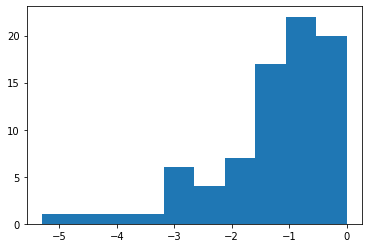

In [57]:
# What is the distribution of rho currently present in the ensemble?
plt.hist(np.log(og_rho))

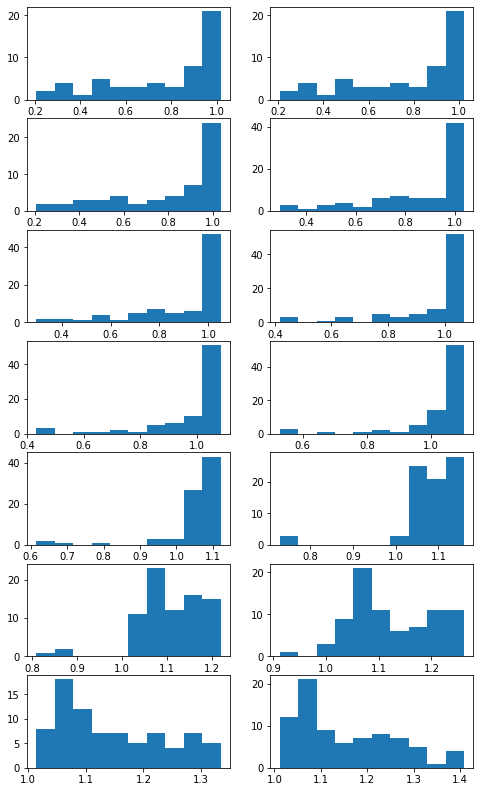

In [62]:
fig, ax = plt.subplots(7, 2, figsize = (8, 14))

# Generate histograms for each sparsity
for i in range(sparsity.size):
    a = ax[np.unravel_index(i, (7, 2))]
    a.hist(og_eta[:, i])

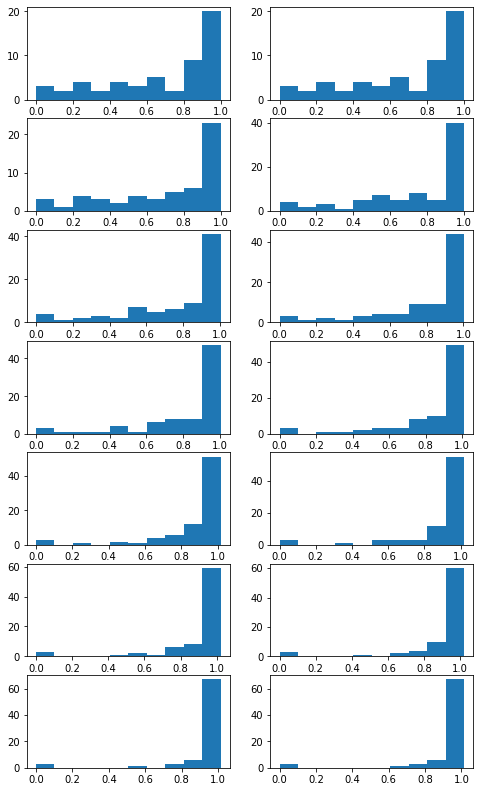

In [61]:
fig, ax = plt.subplots(7, 2, figsize = (8, 14))

# Generate histograms for each sparsity
for i in range(sparsity.size):
    a = ax[np.unravel_index(i, (7, 2))]
    a.hist(og_eta2[:, i])
    

### Generate an expanded ensemble to play with

In [63]:
sigma1 = gen_covariance(p, **og_cov_params[0])
sigma2 = gen_covariance(p, **og_cov_params[1])

In [123]:
# generate the standard covariance ensemble
p = 500

# n determines the strength of perturbation
n = np.linspace(500, 2000, 5)
nreps = 25

# Do not include fully dense model
sparsity = np.logspace(np.log10(0.02), 0, 15)[:-1]

rho = np.zeros((len(cov_params), n.size, nreps))
eta1 = np.zeros((len(cov_params), n.size, nreps, sparsity.size))        
eta2 = np.zeros(eta1.shape)

for i1, cov_param in enumerate(cov_params):
    
    for i2, n_ in enumerate(n):
    
        t0 = time.time()

        # Generate 500 Wishart matrices seeded by this particular sigma
        sigma = gen_covariance(p, **cov_param)

        for rep in range(nreps):
            # With knowledge of the rep, n, and sigma, the covariance matrix can be reproduced using 
            # this random seed
            random_state = RandomState(rep)            
            sigma_rep = wishart.rvs(df=n, scale=sigma, random_state=random_state)
            for i3, s in enumerate(sparsity):
                # Keep the nonzero components of beta fixed for each sparsity
                # Here, we ensure that blocks are treated equally

                subset = sparsify_beta(np.ones((p, 1), dtype=int), block_size=cov_param['block_size'], 
                                       sparsity = s, seed = s).ravel()

                if len(np.nonzero(subset)[0]) == 0:
                    rho[i1, rep, i3] = np.nan
                    eta[i1, rep, i3] = np.nan
                    continue

                else:

                    rho_ = 1/calc_eigenvalue(np.linalg.inv(sigma_rep), np.nonzero(subset)[0])
                    rho[i1, rep, i3] = rho_ 

                    eta[i1, rep, i3] = calc_irrep_const(sigma_rep, np.nonzero(subset)[0])
                
        print(time.time() - t0)

        print('%d/%d' % (i1 + 1, len(cov_params)))
    

63.60861587524414
1/80
59.49524641036987
2/80
54.26375865936279
3/80
49.9421751499176
4/80
56.537397146224976
5/80
54.58986687660217
6/80
51.74505090713501
7/80
56.19660544395447
8/80
55.38501739501953
9/80
50.9654438495636
10/80
57.250025510787964
11/80
54.831095933914185
12/80
50.47407126426697
13/80
55.8282527923584
14/80
55.50596070289612
15/80
53.0787239074707
16/80
55.943060874938965
17/80
55.019898891448975
18/80
54.91848683357239
19/80
49.79276084899902
20/80
50.59603762626648
21/80
56.88428735733032
22/80
55.63915491104126
23/80
56.60812997817993
24/80
56.98773241043091
25/80
52.438987255096436
26/80
50.830336809158325
27/80
56.56634545326233
28/80
55.704989433288574
29/80
52.32727074623108
30/80
50.75086259841919
31/80
55.49715542793274
32/80
60.97416949272156
33/80
54.456918716430664
34/80
57.10381865501404
35/80
55.667457580566406
36/80
57.0866801738739
37/80
55.77369689941406
38/80
51.23842406272888
39/80
57.482139587402344
40/80
56.30531311035156
41/80
50.640626192092896


In [104]:
# The results suggest that drawing from a Wishart distribution dramatically changes the eigenvalue bound. 
# Does this hold true or is it a consequence of normalization?

cov_param = {'correlation' : 0.33, 'block_size' : 50, 'L' : 1, 't': 0} 
sparsity = np.logspace(np.log10(0.02), 0, 15)[:-1]

sigma = gen_covariance(500, **cov_param)

nreps = 20
n = [2000, 4000, 8000, 16000, 32000, 64000]

rho0 = 1/eigsh(np.linalg.inv(sigma), 1, which='LM', return_eigenvectors=False)[0]
rho = np.zeros((len(n), nreps))
sigma_reps = np.zeros((sigma.shape) + (len(n), nreps))
    
for nidx, n_ in enumerate(n):
    
    for rep in range(nreps):

        rand_seed = rep
        random_state = RandomState(rand_seed)

        sigma_rep = invwishart.rvs(df=n_, scale=sigma, random_state=random_state)
        # Normalize
        D = np.sqrt(np.diag(np.diag(sigma_rep)))
        sigma_rep = np.abs(np.linalg.inv(D) @ sigma_rep @ np.linalg.inv(D))
        sigma_reps[...,nidx, rep] = sigma_rep
        
        rho[nidx, rep] = 1/eigsh(np.linalg.inv(sigma_rep), 1, which='LM', return_eigenvectors=False)[0]

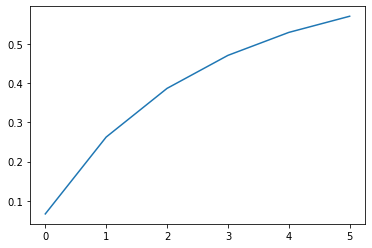

In [106]:
plt.plot(np.mean(rho, axis = 1))